# Powerlaw red noise fitting example

This notebook corresponds to Section 6.3 of Susobhanan+ 2024.

In [33]:
from enterprise.pulsar import Pulsar
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import TimingModel
from enterprise.signals.signal_base import PTA
from enterprise_extensions.blocks import red_noise_block

from pint.models import get_model_and_toas, get_model
from pint.fitter import WLSFitter
from pint.logging import setup as setup_log
from pint.utils import akaike_information_criterion, plrednoise_from_wavex

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
import matplotlib.pyplot as plt
import astropy.units as u
from copy import deepcopy

In [6]:
setup_log(level="WARNING")

2

## Estimate the optimal number of harmonics using AIC

In [8]:
# I did an initial fit using pintk. 
# sim3.wx1.par is the result of that.
m, t = get_model_and_toas("sim3.wx1.par", "sim3.tim")

Tspan = t.get_mjds().max() - t.get_mjds().min()

aics = []
idxs = m.components["WaveX"].get_indices()

ftr = WLSFitter(t, m)
ftr.fit_toas(maxiter=3)
aic = akaike_information_criterion(ftr.model, t)
aics += [aic]
print(f"{len(idxs)}\t{aic}\t{ftr.resids.chi2_reduced}")

for idx in reversed(idxs):
    if idx == 1:
        m.remove_component("WaveX")
    else:
        m.components["WaveX"].remove_wavex_component(idx)

    ftr = WLSFitter(t, m)
    ftr.fit_toas(maxiter=3)
    aic = akaike_information_criterion(ftr.model, t)
    aics += [aic]
    print(f"{idx-1}\t{aic}\t{ftr.resids.chi2_reduced}")


45	-52432.9767536096	1.0371040319028193
44	-52436.46021640554	1.0362863569108247
43	-52439.67402709038	1.035611798232972
42	-52441.52772678135	1.0356511260027845
41	-52443.43409746433	1.035662809448633
40	-52442.107543404265	1.037364444807318
39	-52443.18047839778	1.0378095289414535
38	-52446.469101712515	1.0370978740783259
37	-52449.96476032278	1.0362798155278201
36	-52453.9399124731	1.035213854163228
35	-52455.75136736553	1.0352752776677765
34	-52456.85571384944	1.0357039025824537
33	-52459.611839985366	1.0352744609939286
32	-52462.69416669702	1.0346768064404581
31	-52466.12506493343	1.0338998764304672
30	-52468.33096944894	1.033758280844138
29	-52469.899101684925	1.0339465760391415
28	-52470.26985881401	1.034752641975554
27	-52468.42961429626	1.0366973244066016
26	-52468.28393340315	1.0377649628632206
25	-52469.246494471816	1.038260026684944
24	-52471.42727477765	1.0381277385825285
23	-52471.389052663304	1.0391354256072742
22	-52470.18976699992	1.0407367672245973
21	-52472.306940234

In [11]:
d_aics = np.array(aics) - np.min(aics)
nharm_opt = len(d_aics) - 1 - np.argmin(d_aics)

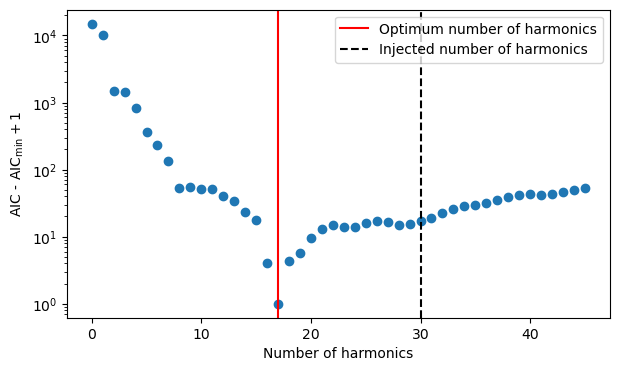

In [12]:
plt.figure(figsize=(7, 4))
plt.scatter(list(reversed(range(len(d_aics)))), d_aics+1)
plt.axvline(nharm_opt, color="red", label="Optimum number of harmonics")
plt.axvline(30, color="black", ls="--", label="Injected number of harmonics")
plt.xlabel("Number of harmonics")
plt.ylabel("AIC - AIC$_\\min{} + 1$")
plt.legend()
plt.yscale("log")
plt.savefig("sim3-aic.pdf")

## Fit for the WaveX parameters

In [13]:
m, t = get_model_and_toas("sim3.wx1.par", "sim3.tim")

Tspan = t.get_mjds().max() - t.get_mjds().min()

idxs = m.components["WaveX"].get_indices()
for idx in reversed(idxs):
    if idx > nharm_opt:
        m.components["WaveX"].remove_wavex_component(idx)

ftr = WLSFitter(t, m)
ftr.fit_toas(maxiter=5)

print(ftr.model)

# Created: 2024-04-23T13:42:06.295102
# PINT_version: 0.9.8+313.gbdb54a71
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-28-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                                  SIM3
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999566487616
FINISH             56985.0000000463726042
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   2034.3446571369059
CHI2R                  1.0384607744445664
TRES                1.0166289687265969849
RAJ                      5:00:00.00017315 1 0.00011139189982041148
DECJ                    14:59:59.98792421 1 0.01183671859050529178
PMRA                                  0.0
PMDEC                  

## Fit the WaveX amplitudes to get the powerlaw spectral parameters

In [14]:
idxs = np.array(ftr.model.components["WaveX"].get_indices())
a = np.array([ftr.model[f"WXSIN_{idx:04d}"].quantity.to_value("s") for idx in idxs])
da = np.array([ftr.model[f"WXSIN_{idx:04d}"].uncertainty.to_value("s") for idx in idxs])
b = np.array([ftr.model[f"WXCOS_{idx:04d}"].quantity.to_value("s") for idx in idxs])
db = np.array([ftr.model[f"WXCOS_{idx:04d}"].uncertainty.to_value("s") for idx in idxs])

In [15]:
P = (a**2 + b**2) / 2
dP = ((a*da)**2 + (b*db)**2)**0.5

In [18]:
m_plrn = get_model("sim3.par")
print(m_plrn)

# Created: 2024-04-23T13:43:21.027886
# PINT_version: 0.9.8+313.gbdb54a71
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-28-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                                  SIM3
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
RAJ                      5:00:00.00000000 1 0.00000000000000000000
DECJ                    15:00:00.00000000 1 0.00000000000000000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                                  100.0 1 0.0
F1                                 -1e-15 1 0.0
PEPOCH             55000.0000000000000000
PLANET_SHAP

In [19]:
P_plrn = m_plrn.components["PLRedNoise"].get_noise_weights(t)

## Bayesian analysis using ENTERPRISE

In [22]:
psr = Pulsar("sim3.par", "sim3.tim", timing_package="pint")

In [23]:
wn = MeasurementNoise(efac=1)
tm = TimingModel()
rn = red_noise_block(components=nharm_opt)

In [24]:
model = wn + tm + rn

In [25]:
pta = PTA([model(psr)])

In [26]:
ndim = len(pta.param_names)
x0 = np.array([p.sample() for p in pta.params])
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/sim3/"
Niter = 100000

In [27]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [28]:
sampler.sample(
    x0,
    Niter,
)

Finished 1.00 percent in 0.292355 s Acceptance rate = 1

WARNING  (pint.logging                  ): /home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.10/site-packages/enterprise/signals/parameter.py:62 RuntimeWarning: divide by zero encountered in log


Finished 10.00 percent in 2.067772 s Acceptance rate = 0.20852Adding DE jump with weight 20
Finished 99.00 percent in 20.365922 s Acceptance rate = 0.243535
Run Complete


In [29]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]

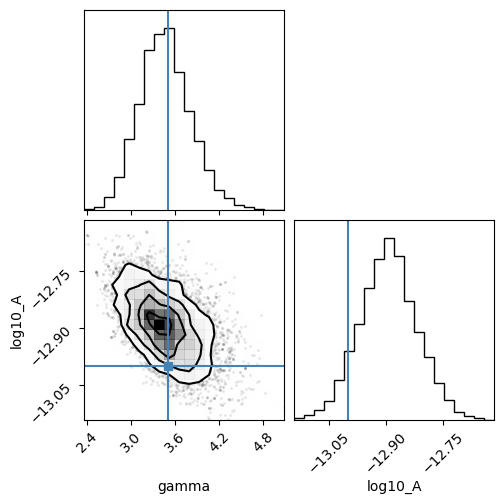

In [30]:
fig = corner.corner(
    burned_chain, 
    labels=["gamma", "log10_A"], 
    truths=[m_plrn.TNREDGAM.value, m_plrn.TNREDAMP.value],
)

In [31]:
gamma_e, log10_A_e = np.median(burned_chain, axis=0)

m_ent = deepcopy(m_plrn)
m_ent.TNREDAMP.value = log10_A_e
m_ent.TNREDGAM.value = gamma_e
P_ent = m_ent.components["PLRedNoise"].get_noise_weights(t)

In [35]:
m_pint_1 = plrednoise_from_wavex(ftr.model)

P_pint_1 = m_pint_1.components["PLRedNoise"].get_noise_weights(t)

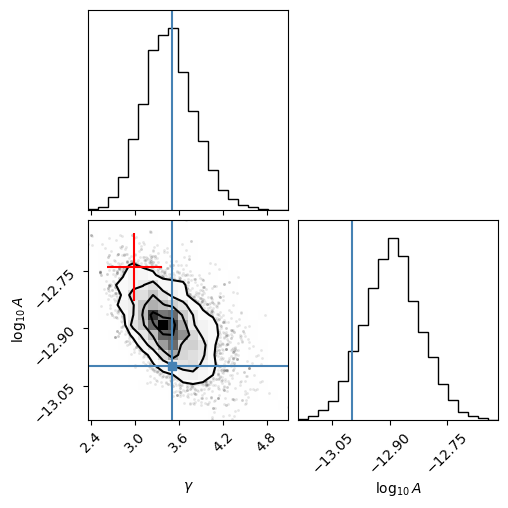

In [36]:
fig = corner.corner(
    burned_chain, 
    labels=["$\\gamma$", "$\\log_{10} A$"], 
    truths=[m_plrn.TNREDGAM.value, m_plrn.TNREDAMP.value],
)

plt.subplot(223)
plt.errorbar([m_pint_1.TNREDGAM.value], [m_pint_1.TNREDAMP.value], 
             xerr=[m_pint_1.TNREDGAM.uncertainty_value], yerr=[m_pint_1.TNREDAMP.uncertainty_value], 
             color="red")

plt.savefig("sim3-param.pdf")

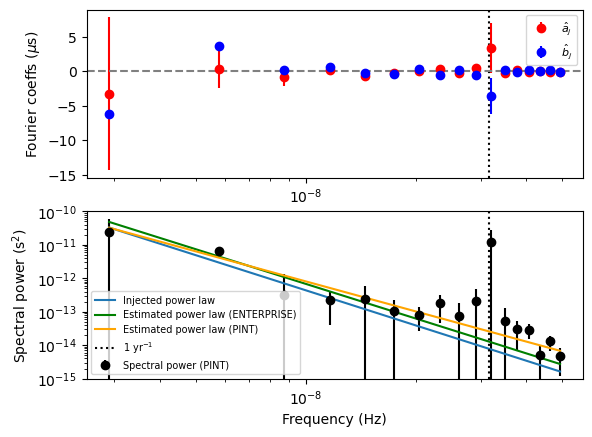

In [37]:
f0 = (1/Tspan).to_value("Hz")
fyr = (1 / u.year).to_value("Hz")

plt.subplot(211)
plt.errorbar(idxs*f0, b*1e6, db*1e6, ls="", marker="o", label="$\\hat{a}_j$", color="red")
plt.errorbar(idxs*f0, a*1e6, da*1e6, ls="", marker="o", label="$\\hat{b}_j$", color="blue")
plt.axvline(fyr, color="black", ls="dotted")
plt.axhline(0, color="grey", ls="--")
plt.ylabel("Fourier coeffs ($\mu$s)")
plt.xscale("log")
plt.legend(fontsize=8)

plt.subplot(212)
plt.errorbar(idxs*f0, P, dP, ls="", marker="o", label="Spectral power (PINT)", color="k")
plt.plot(idxs*f0, P_plrn[::2][:nharm_opt], label="Injected power law")
plt.plot(idxs*f0, P_ent[::2][:nharm_opt], label="Estimated power law (ENTERPRISE)", color="green")
plt.plot(idxs*f0, P_pint_1[::2][:nharm_opt], label="Estimated power law (PINT)", color="orange")
# plt.plot(idxs*f0, P_pint_0[::2][:nharm_opt], label="Estimated power law (PINT)", color="violet")
plt.axvline(fyr, color="black", ls="dotted", label="1 yr$^{-1}$")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Spectral power (s$^2$)")
plt.xlabel("Frequency (Hz)")
plt.legend(fontsize=7)

plt.savefig("sim3-spec.pdf")

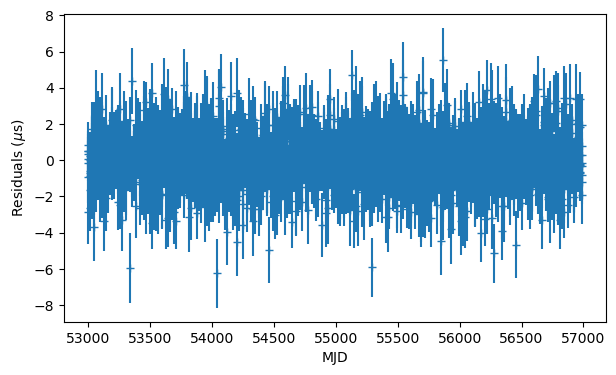

In [38]:
plt.figure(figsize=(7, 4))
plt.errorbar(ftr.toas.get_mjds(), ftr.resids.time_resids.to("us"), ftr.resids.get_data_error().to("us"), ls="", marker="+")
plt.ylabel("Residuals ($\\mu$s)")
plt.xlabel("MJD")
plt.savefig("sim3-resids.pdf")